# CR 2210$\rightarrow$ *2018-10-26 $\to$ 2018-11-23*

Authors: Opal Issan

Last modified: Nov 23rd, 2022

In [1]:
import numpy as np
import datetime as dt
import astropy.units as u
from tools.interpolate import interpolate_ace_data, interp_2d_ace_hux
import time
from sunpy.coordinates import frames
from astropy.coordinates import SkyCoord
from sunpy.coordinates.sun import carrington_rotation_time
from heliopy.data import ace
from HUX.hux_propagation import apply_hux_f_model
import matplotlib
import matplotlib.pyplot as plt
import astropy.constants as const
import sunpy.map
import os
import scipy
import pfsspy
import astropy
from pfsspy import tracing
from model_chain import get_ace_date, pfss2flines, distance_to_coronal_hole_boundary, run_chain_of_models
import matplotlib.dates as mdates

plt.rcParams['savefig.facecolor'] = 'white'
font = {'family': 'serif',
        'size': 12}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

# Set time period

In [2]:
CR = "2210"
start_time = carrington_rotation_time(int(CR))
end_time = carrington_rotation_time(int(CR)+1)
print(start_time)
print(end_time)

2018-10-26 20:48:16.137
2018-11-23 04:07:55.576


In [3]:
new_dir = os.getcwd() + "/figs/CR" + str(CR) + "/"
if not os.path.exists(new_dir):
    os.makedirs(new_dir)

In [4]:
start_time = dt.datetime(year=2019, month=3, day=12, hour=11, minute=59, second=2)
end_time = dt.datetime(year=2019, month=4, day=8, hour=19, minute=8, second=15)

# ACE Trajectory and Observations

In [5]:
ACE_longitude, ACE_latitude, ACE_r, ACE_vr, ACE_obstime = get_ace_date(start_time=start_time, end_time=end_time)

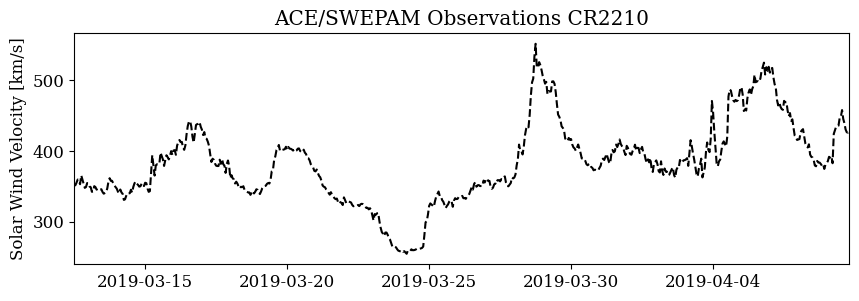

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(ACE_obstime, ACE_vr, c="k", ls="--")
ax.set_xlim(ACE_obstime[0], ACE_obstime[-1])
ax.set_ylabel("Solar Wind Velocity [km/s]")
ax.set_title("ACE/SWEPAM Observations CR" + str(CR))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

# GONG Magnetograms

## Read data from NSO website

Observatory,NSO-GONG
Instrument,
Detector,
Measurement,676.8
Wavelength,676.8
Observation Date,2018-12-01 23:54:00
Exposure Time,Unknown
Dimension,[360. 180.] pix
Coordinate System,heliographic_carrington
Scale,[1. 0.63661914] deg / pix
Reference Pixel,[179.5 89.5] pix

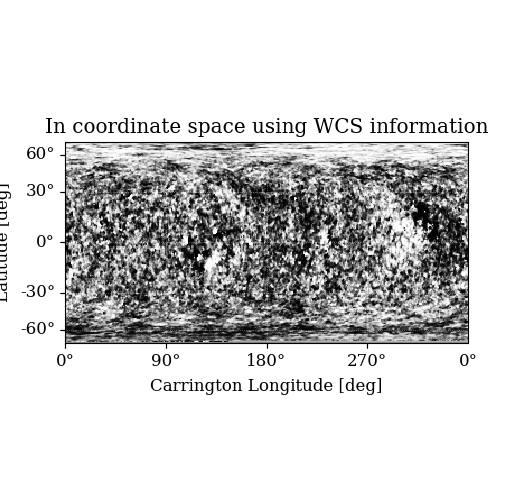
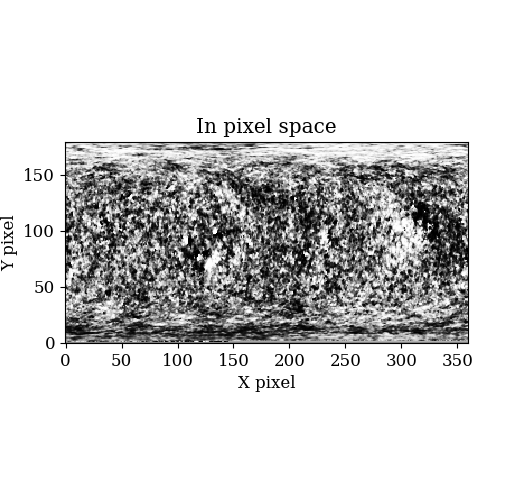
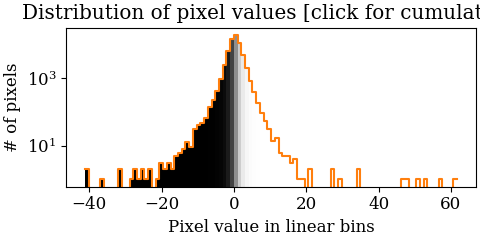
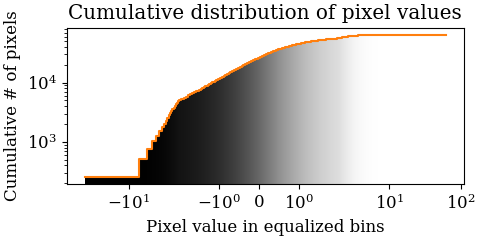

In [7]:
gong_map = sunpy.map.Map('GONG/CR' + str(CR) + '/mrmqs181109t1232c2210_000.fits.gz')
gong_map

# PFSS

The PFSS model [(Wang et al. 1992)](https://ui.adsabs.harvard.edu/abs/1992ApJ...392..310W/abstract) solves for the magnetic field $\mathbf{B} = [B_{r}(r, \theta, \phi), B_{\theta}(r, \theta, \phi), B_{\phi}(r, \theta, \phi)]^{\top} \in \mathbb{R}^{3}$, where $\theta \in [0, \pi]$ is Carrington latitude, $\phi \in [0, 2\pi]$ is Carrington longitude, and $r \in [1 R_{S}, r_{\text{PFSS}} ] $ is the radial distance from the center of the Sun. PFSS is an elliptic boundary value problem, satisfying
\begin{equation}\label{curl-b-zero}
   \nabla \times \mathbf{B} = 0
\end{equation}
and 
\begin{equation}\label{div-b-zero}
    \nabla \cdot \mathbf{B} =0.
\end{equation}
We can describe the magnetic field by its potential,
\begin{equation}\label{potential-def}
    \mathbf{B} = \nabla \Psi.
\end{equation}
Then, we obtain the laplace equation
\begin{equation}
    \nabla^2 \Psi = 0, 
\end{equation}
subject to 
\begin{align}
    \frac{\partial \Psi}{\partial r}(r=1, \theta, \phi) &= g(\theta, \phi),\\
    \frac{\partial \Psi}{\partial \theta} (r = r_{\text{PFSS}}, \theta, \phi) &= \frac{\partial \Psi}{\partial \phi} (r=r_{\text{PFSS}}, \theta, \phi) = 0,\\
    \Psi(r= r_{\text{PFSS}}, \theta, \phi) &= 0,\\
    \Psi(r, \theta, \phi=0) &= \Psi(r, \theta, \phi=2\pi),\\
    \Psi(r, \theta=\{0, \pi\}, \phi) &= \frac{1}{2\pi} \int_{\phi=0}^{\phi=2\pi} \Psi(r, \theta=\{0 \pm \epsilon, \pi \pm \epsilon\}, \phi) \text{d} \phi,
\end{align}
where $g(\theta, \phi)$ is set to the GONG data. The PFSS model can be solved via finite-difference numerical schemes or alternatively by spherical harmonic expansion. The upper boundary is usually set to $r_{\text{PFSS}} = 2.5 R_{S}$ to best match observations. 

In [8]:
# pfss parameters + simulate
pfss_in = pfsspy.Input(br=gong_map, nr=100, rss=2.5)
pfss_out = pfsspy.pfss(pfss_in)

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/pfsspy/output.py:95: UserWarning: Could not parse unit string "GAUSS" as a valid FITS unit.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards.
  warnings.warn(f'Could not parse unit string "{unit_str}" as a valid FITS unit.\n'


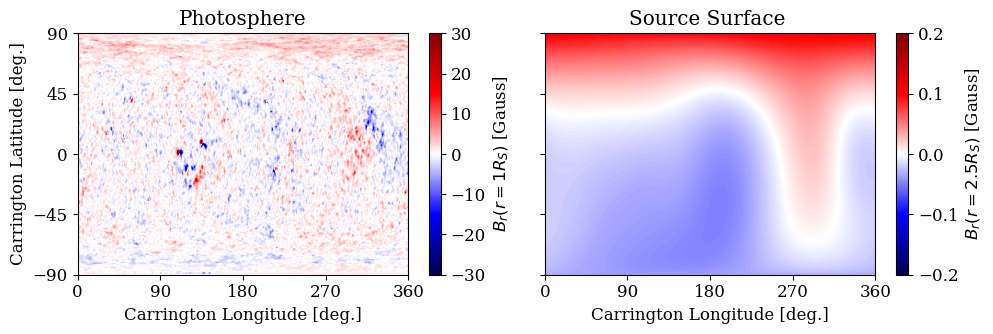

In [9]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 3.5))
pos = ax[0].imshow(gong_map.data, extent=[0,360,-90, 90], origin="lower", aspect="auto", cmap="seismic", vmin=-30, vmax=30)

ax[0].set_xticks([0, 90, 180, 270, 360])
ax[0].set_yticks([-90, -45, 0, 45, 90])
cbar = fig.colorbar(pos, ax=ax[0], orientation="vertical")
cbar.ax.set_ylabel(r'$B_{r}(r=1R_{S})$ [Gauss]', rotation=90)
ax[0].set_xlim(0, 360)
ax[0].set_xlabel("Carrington Longitude [deg.]")
ax[0].set_ylabel("Carrington Latitude [deg.]")
ax[0].set_title("Photosphere")
plt.tight_layout()

pos = ax[1].imshow(pfss_out.source_surface_br.data, extent=[0,360,-90, 90], origin="lower", aspect="auto", cmap="seismic", vmin=-0.2, vmax=0.2)
cbar = fig.colorbar(pos, ax=ax[1], orientation="vertical")
cbar.ax.set_ylabel(r'$B_{r}(r=2.5R_{S})$ [Gauss]', rotation=90)
ax[1].set_xlabel("Carrington Longitude [deg.]")
#ax[1].plot(pfss_out.source_surface_pils[0].lon, pfss_out.source_surface_pils[0].lat)
ax[1].set_title("Source Surface ")
plt.savefig("figs/CR" + str(CR) + "/pfss_result_cr" + str(CR) + ".png")

In [10]:
tracer = tracing.FortranTracer()
r = 1.2 * const.R_sun
lat = np.linspace(-np.pi / 2, np.pi / 2, 15)
lon = np.linspace(0, 2 * np.pi, 15)
lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel() * u.rad, lon.ravel() * u.rad

seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
field_lines = tracer.trace(seeds, pfss_out)

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to auto) and try again.
  warnings.warn(


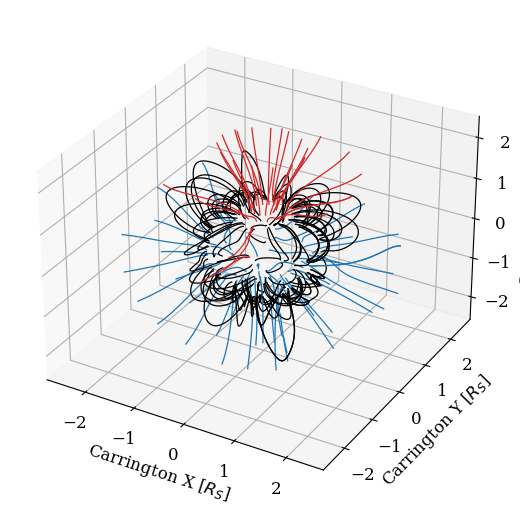

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

for field_line in field_lines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
    coords = field_line.coords
    coords.representation_type = 'cartesian'
    ax.plot(coords.x / const.R_sun,
            coords.y / const.R_sun,
            coords.z / const.R_sun,
            color=color, linewidth=0.9)
ax.set_xlabel(r"Carrington X [$R_{S}$]")
ax.set_ylabel(r"Carrington Y [$R_{S}$]")
ax.set_zlabel(r"Carrington Z [$R_{S}$]")
plt.savefig("figs/CR" + str(CR) + "/PFSS_field_lines_spherical_cr"+ str(CR) + ".png", dpi=600)

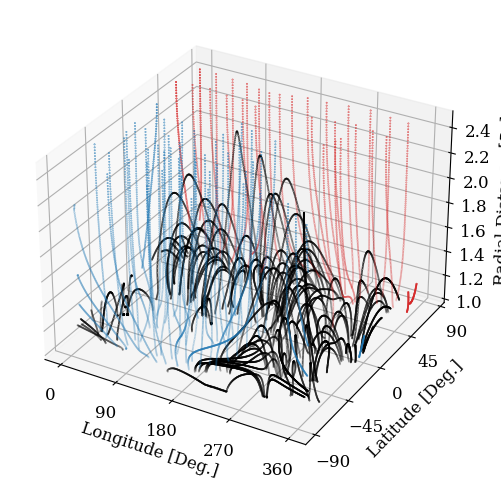

In [12]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

for field_line in field_lines:
    color = {0: 'black', -1: 'tab:blue', 1: 'tab:red'}.get(field_line.polarity)
    coords = field_line.coords
    coords.representation_type = 'spherical'
    ax.scatter(
            coords.lon.value,
            coords.lat.value,
            coords.radius / const.R_sun,
            color=color, s=0.1)

ax.set_zlim(1, 2.5)
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_yticks([-90, -45, 0, 45, 90])
ax.set_xlabel("Longitude [Deg.]")
ax.set_ylabel("Latitude [Deg.]")
ax.set_zlabel(r"Radial Distance [$R_{S}$]")
plt.tight_layout()
plt.savefig("figs/CR" + str(CR) + "/PFSS_field_lines_cartesian_cr" + str(CR) + ".png", dpi=600)

In [13]:
# trace the magnetic field lines for the ACE projection to obtain the expansion factor
tracer = tracing.FortranTracer()
seeds = SkyCoord(ACE_longitude.to(u.rad), ACE_latitude.to(u.rad), 2.5*u.solRad, frame=pfss_out.coordinate_frame)
field_lines_fp = tracer.trace(seeds, pfss_out)
fp_ace_traj = field_lines_fp.expansion_factors

# Magnetic Expansion Factor

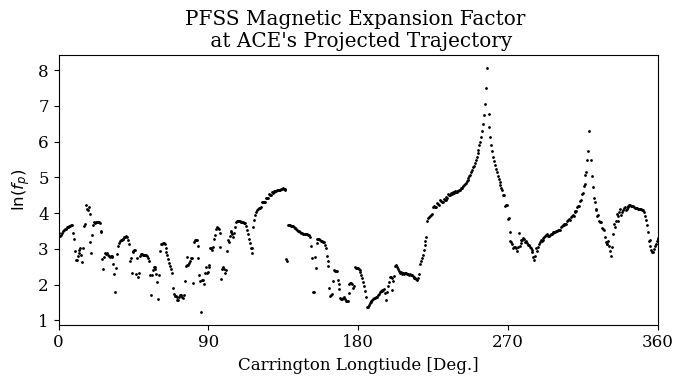

In [14]:
fig, ax = plt.subplots(figsize=(7,4))
_ = ax.scatter(ACE_longitude, np.log(fp_ace_traj), s=1, c="k")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_xlim(0, 360)
_ = ax.set_xlabel("Carrington Longtiude [Deg.]")
_ = ax.set_title("PFSS Magnetic Expansion Factor \n at ACE's Projected Trajectory")
_ = ax.set_ylabel("$\ln(f_{p})$")
plt.tight_layout()
plt.savefig("figs/CR" + str(CR) + "/magentic_expansion_factor_cr" + str(CR) + ".png", dpi=800)

# Coronal Hole Mapping

In [15]:
topologies = pfss2flines(pfss_out)
expansion_factor = pfss2flines(pfss_out, trace_from_SS=True)

/opt/anaconda3/envs/hux-rom/lib/python3.9/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


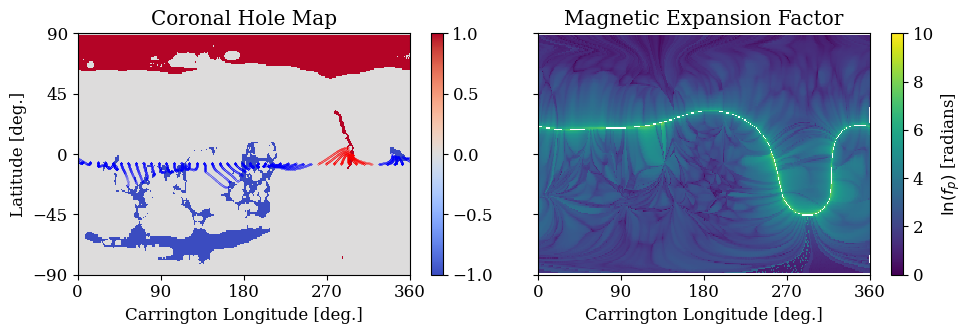

In [16]:
lons = np.linspace(0,360,361)
lats = np.linspace(-90,90,181)

fig,ax = plt.subplots(ncols =2, sharex=True, sharey=True, figsize=(10,3.5))

pos = ax[0].pcolormesh(lons,lats, topologies,cmap='coolwarm')
cbar = fig.colorbar(pos, ax=ax[0], orientation="vertical")
cbar.ax.set_ylabel(r'', rotation=90)

pos = ax[1].pcolormesh(lons,lats,np.log(expansion_factor), vmin=0, vmax=10)
cbar = fig.colorbar(pos, ax=ax[1], orientation="vertical")
cbar.ax.set_ylabel(r'$\ln(f_{p})$ [radians]', rotation=90)

_ = ax[0].set_xlabel("Carrington Longitude [deg.]")
_ = ax[1].set_xlabel("Carrington Longitude [deg.]")
_ = ax[0].set_ylabel("Latitude [deg.]")
_ = ax[0].set_xticks(np.linspace(0,360,5))
_ = ax[0].set_yticks(np.linspace(-90,90,5))
_ = ax[0].set_title(r"Coronal Hole Map")
_ = ax[1].set_title(r"Magnetic Expansion Factor")

for ii in range(7, len(ACE_longitude.to(u.rad))-5):
    if ii % 15==0:
        field_line = field_lines_fp[ii]
        coords = field_line.coords
        color= {0: 'black', -1: 'blue', 1: 'red'}.get(field_line.polarity)
        ax[0].scatter(coords.lon, coords.lat, c=color, s=0.01)

plt.tight_layout()
plt.savefig("figs/CR" + str(CR) + "/coronal_hole_plot_cr" + str(CR) + ".png", dpi=600)

### Great-circle angular distance from the nearest coronal hole boundary at the photosphere $d$

$d = \arccos\left[\cos(\theta_{1}) \cos(\theta_{2}) \cos(\phi_{1}- \phi_{2}) + \sin(\theta_{1}) \sin(\theta_{2})\right]$

In [17]:
d_ace_traj = distance_to_coronal_hole_boundary(topologies, field_lines_fp)

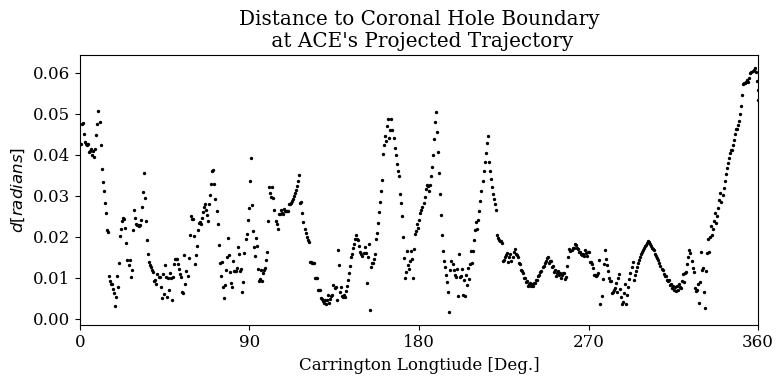

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

_ = ax.scatter(ACE_longitude, d_ace_traj, s=2, c="k")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_xlim(0, 360)
_ = ax.set_xlabel("Carrington Longtiude [Deg.]")
_ = ax.set_title("Distance to Coronal Hole Boundary\n at ACE's Projected Trajectory")
_ = ax.set_ylabel("$d [radians]$")
plt.tight_layout()
plt.savefig("figs/CR" + str(CR) + "/distance_to_coronal_hole_boundary_cr" + str(CR) + ".png", dpi=600)

# WSA

WSA is an empirical model of the ambient solar wind. The WSA model is based on the inverse relationship between the solar wind speed and the magnetic field expansion
factor $f_{p}$ and the minimum angular distance that an open field
footpoint lies from the nearest coronal hole boundary $d$, such that
\begin{equation}
    f_{p} = \left(\frac{1}{r_{\text{SS}}}\right)^2 \left|\frac{B_{r}(r_{0}, \theta_{0}, \phi_{0})}{B_{r}(r_{SS}, \theta_{1}, \phi_{1})} \right|
\end{equation}
where the indicies $0$ and $1$ refer to the longitude and latitude at the solar surface and upper boundary. These values are obtained by tracing the field lines down from $r_{SS}$ using a 4th order Runge Kutta scheme. The WSA model relation is given by 
\begin{equation}
    v_{\text{wsa}}(f_{p}, d) = v_{0} + \frac{v_{1} - v_{0}}{(1+f_{p})^{\alpha}} \left(\beta - \gamma \exp \left(-\left(\frac{d}{\omega}\right)^{\delta} \right)\right)^{\psi}
\end{equation}
The authors in [(Kumar et al. 2020)](https://www.frontiersin.org/articles/10.3389/fspas.2020.572084/full) set $v_{0} = 250 \frac{\text{km}}{\text{s}}$, $v_{1} = 900 \frac{\text{km}}{\text{s}}$, $\alpha = 1.5/9$, $\beta = 1$, $\gamma = 0.8$, $\omega = 0.03$, $\delta = 1.5$, $\psi=3$.


The authors in [(Bailey et al. 2021)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020SW002673) set $v_{0} = 250 \frac{\text{km}}{\text{s}}$, $v_{1} = 650 \frac{\text{km}}{\text{s}}$, $\alpha = 0.19$, $\beta = 1$, $\gamma = 0.8$, $\omega = 3^{\circ}$, $\delta = 1.75$, $\psi = 3$.


The authors in [(Reiss et al. 2016)](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2016SW001390) set $v_{0} = 250 \frac{\text{km}}{\text{s}}$, $v_{1} = 1125 \frac{\text{km}}{\text{s}}$, $\alpha = 0.2$, $\beta = 1$, $\gamma = 0.8$, $\omega = 2.6^{\circ}$, $\delta = 1.25$, $\psi = 2.5$.


In [52]:
# parameter from kumar et al. 2020
v0 = 250
v1 = 950
alpha= 1.5/9
beta = 1
gamma = 0.8
w = 0.03 # to radians
delta = 2
psi=3.5
# dchb
omega = 0.05
epsilon = 0.1
v0_dchb = 350
v1_dchb = 850

In [53]:
v_wsa = v0 + (v1 - v0)/((1+fp_ace_traj)**alpha) * (beta - gamma* np.exp(-(d_ace_traj/w)**delta))**psi
v_ws = v0 + (v1 - v0)/(fp_ace_traj)**alpha
v_dchb = v0 + 0.5*(v1_dchb - v0_dchb) * ( 1+ np.tanh((d_ace_traj - epsilon)/omega))

In [54]:
p_hux = np.linspace(0, 2*np.pi, len(ACE_longitude))

v_wsa_interp = interpolate_ace_data(x=p_hux, xp=ACE_longitude.to(u.rad).value, fp=v_wsa, period=2*np.pi)
v_ws_interp = interpolate_ace_data(x=p_hux, xp=ACE_longitude.to(u.rad).value, fp=v_ws, period=2*np.pi)
v_dchb_interp = interpolate_ace_data(x=p_hux, xp=ACE_longitude.to(u.rad).value, fp=v_dchb, period=2*np.pi)

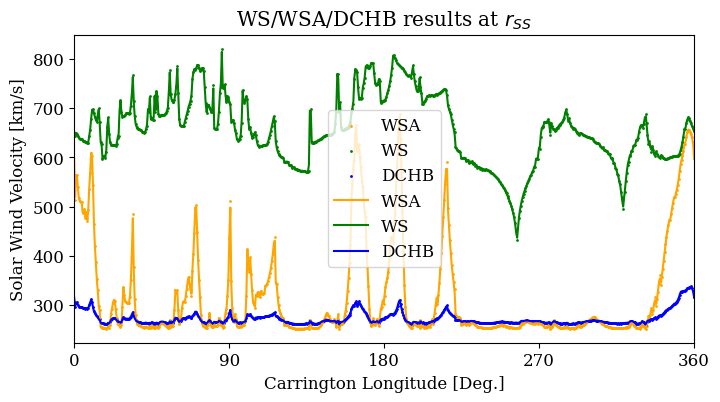

In [55]:
fig, ax = plt.subplots(figsize=(8, 4))
_ = ax.scatter(ACE_longitude, v_wsa, c="orange", label="WSA", s=1)
_ = ax.scatter(ACE_longitude, v_ws,  label="WS",c="green", s=1)
_ = ax.scatter(ACE_longitude, v_dchb,label="DCHB", c="blue",s=1)
_ = ax.plot(p_hux*180/np.pi, v_wsa_interp, c="orange",label="WSA")
_ = ax.plot(p_hux*180/np.pi, v_ws_interp, c="green", label="WS")
_ = ax.plot(p_hux*180/np.pi, v_dchb_interp, c="blue",label="DCHB")
_ = ax.set_xticks([0, 90, 180, 270, 360])
_ = ax.set_xlim(0, 360)
#_ = ax.set_ylim(0, 900)
_ = ax.set_xlabel("Carrington Longitude [Deg.]")
_ = ax.set_ylabel("Solar Wind Velocity [km/s]")
_ = ax.set_title(r"WS/WSA/DCHB results at $r_{SS}$")
_ = ax.legend()

In [56]:
r_vec = (np.linspace(2.5, np.max(ACE_r.to(u.solRad)).value, 300) * u.solRad).to(u.km).value
dr_vec = r_vec[1:] - r_vec[:-1]
dp_vec = p_hux[1:] - p_hux[:-1]

vr_hux_wsa = apply_hux_f_model(initial_condition=v_wsa_interp, dr_vec=dr_vec, dp_vec=dp_vec, alpha=0.15, r0=2.5, rh=50, theta=np.mean(np.pi/2 - ACE_latitude.to(u.rad).value))
vr_hux_ws = apply_hux_f_model(initial_condition=v_ws_interp, dr_vec=dr_vec, dp_vec=dp_vec, alpha=0.15, r0=2.5, rh=50, theta=np.mean(np.pi/2 - ACE_latitude.to(u.rad).value))
vr_hux_dchb = apply_hux_f_model(initial_condition=v_dchb_interp, dr_vec=dr_vec, dp_vec=dp_vec, alpha=0.15, r0=2.5, rh=50, theta=np.mean(np.pi/2 - ACE_latitude.to(u.rad).value))

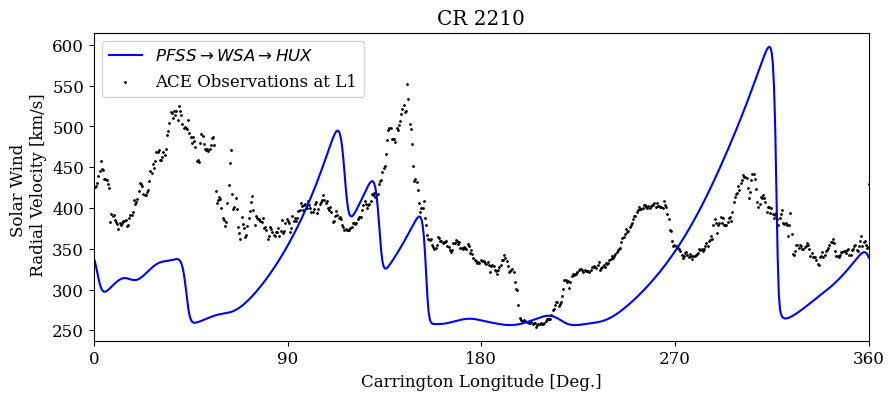

In [57]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(p_hux*180/np.pi, vr_hux_wsa[-1, :], "b", label=r"$PFSS \rightarrow WSA \rightarrow HUX$")
#ax.plot(p_hux*180/np.pi, vr_hux_ws[-1, :], "r", label=r"$PFSS \rightarrow WS \rightarrow HUX$")
#ax.plot(p_hux*180/np.pi, vr_hux_dchb[-1, :], "orange", label=r"$PFSS \rightarrow DCHB \rightarrow HUX$")
ax.scatter(ACE_longitude, ACE_vr, s=1, c="k", label="ACE Observations at L1")
ax.set_title("CR "+ str(CR))
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_xlim(0, 360)
ax.set_xlabel("Carrington Longitude [Deg.]")
ax.set_ylabel("Solar Wind \n Radial Velocity [km/s]")
ax.legend()

In [58]:
vr_wsa_interp = interp_2d_ace_hux(p_hux, r_vec, vr_hux_wsa, ACE_r, ACE_longitude)
vr_ws_interp = interp_2d_ace_hux(p_hux, r_vec, vr_hux_ws, ACE_r, ACE_longitude)

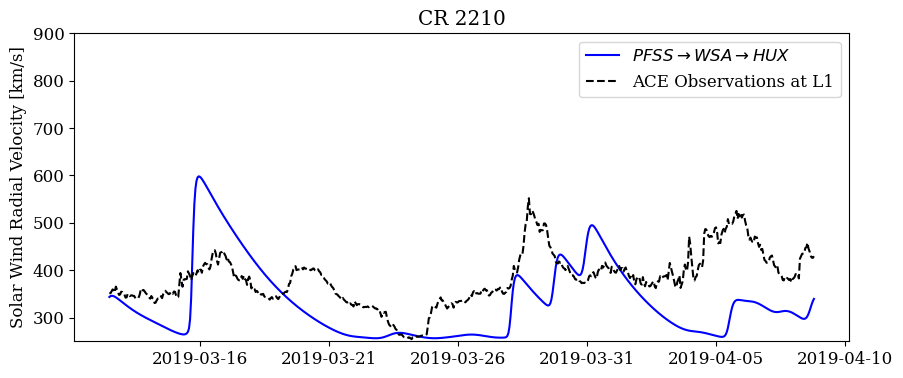

In [59]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ACE_obstime, vr_wsa_interp, "b", label=r"$PFSS \rightarrow WSA \rightarrow HUX$")
ax.plot(ACE_obstime,  ACE_vr, c="k", ls="--", label="ACE Observations at L1")
ax.set_title("CR " + str(CR))
ax.set_ylabel("Solar Wind Radial Velocity [km/s]")
ax.legend()
ax.set_ylim(250, 900)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.savefig("figs/CR" + str(CR) + "/ACE_radial_velocity_cr" + str(CR) + ".png", dpi=600)

# test function *model_chain.py*

In [ ]:
coefficients = np.array([2.5, 250, 950, 1.5 / 9, 1, 0.02, 0.8, 1.5, 3.5, 0.15, 50])
# get gong synoptic map
gong_map = sunpy.map.Map('GONG/CR' + str(CR) + '/mrmqs181109t1232c2210_000.fits.gz')

stime = time.time()
run_chain_of_models(ACE_longitude=ACE_longitude,
                    ACE_latitude=ACE_latitude,
                    ACE_r=ACE_r,
                    ACE_vr=ACE_vr,
                    gong_map=gong_map,
                    coefficients_vec=coefficients,
                    QoI="ALL", 
                    sample_id="test_1",
                    CR=CR)
print(time.time() - stime)

In [ ]:
pred_HUX_SA = np.load("SA_results/CR+" + str(CR) + "/simulation_output/test_1/vr_hux_sample_test_1.npy")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ACE_obstime, vr_wsa_interp, "b", label=r"$jupyter$")
ax.plot(ACE_obstime, pred_HUX_SA, "r", ls="--", label=r"$module$")
ax.set_title("CR " + str(CR))
ax.set_ylabel("Solar Wind Radial Velocity [km/s]")
ax.legend()
ax.set_ylim(250, 900)